# Using TigerGraph CoPilot

This notebook demostrates how to use TigerGraph CoPilot (Public Alpha), an AI assistant for your TigerGraph databases. TigerGraph CoPilot enables you to ask questions in natural language about your graph data, leveraging your installed queries to answer the questions. It will determine the best query needed to answer your question, run the query, and return the results based on the data you have access to. By sticking with pre-defined queries, CoPilot provides strong guardrails: clarity of the meaning of each query, and solid understanding of the consequences. 

## Prerequisites

First of all, a running TigerGraph database with version 3.9+ is required. The easist way to get a database running is through [TigerGraph Cloud](https://tgcloud.io). To run TigerGraph in your own environment, please refer to the [official doc](https://docs.tigergraph.com/tigergraph-server/current/getting-started/) for details.

Second, we assume you already have the CoPilot service set up. If not, there are two ways to set it up as of now. Later, CoPilot will be available on TigerGraph Cloud as a service.  
1. Please follow the [instructions](https://github.com/tigergraph/CoPilot?tab=readme-ov-file#getting-started) there to set it up. You will download the source code of CoPilot and run it in a docker container. This way you will be able to modify and extend CoPilot yourself.  
2. Or you can pull and run the docker image built by TigerGraph as follows:

    ```bash
    docker run -d -v ./configs/llm_config.json:/llm_config.json -v ./configs/db_config.json:/db_config.json --name copilot -p 80:80 tigergraphml/copilot
    ```
    
    <br>where `llm_config.json` and `db_config.json` are configuration files for your LLM provider and TigerGraph database, respectively. Their structures are specified [here](https://github.com/tigergraph/CoPilot?tab=readme-ov-file#create-llm-provider-configuration-file).
    
Last, we will use Python package `pyTigerGraph` in this notebook to interact with CoPilot. (You can also communicate with the http endpoints of CoPilot directly if you are not using Python.) As CoPilot is under active development, please use the latest version of pyTigerGraph. To install or update pyTigerGraph, simply
```python
pip install -U pyTigerGraph
```

## Create Connections

In [1]:
from pyTigerGraph import TigerGraphConnection

In [2]:
# We first create a connection to the database
conn = TigerGraphConnection(
    host="https://webinar.i.tgcloud.io",
    username="user_1", 
    password="MyPassword1!")

# And then add CoPilot's address to the connection. This address 
# is the host's address where the CoPilot container is running.
conn.ai.configureInquiryAIHost("http://18.222.202.55")

## Ingest Data

If there is already a graph in your TigerGraph database against which you would like to query, then please feel free to skip this section. However, in that case you will probably need to modify the questions below for your own data. 

Otherwise, we will download and ingest an example dataset, the digital infrastructure graph, which is a complex web of modern software system. It consists of vertices such as microservices, containers and bare metal nodes, as well as the relationships between them as edges including how microservices call each other, on which bare metal a container is deployed, and so on. To see the full schema, you can go to GraphStudio after the ingestion is done. A screenshot of the schema is attached below for convenience.

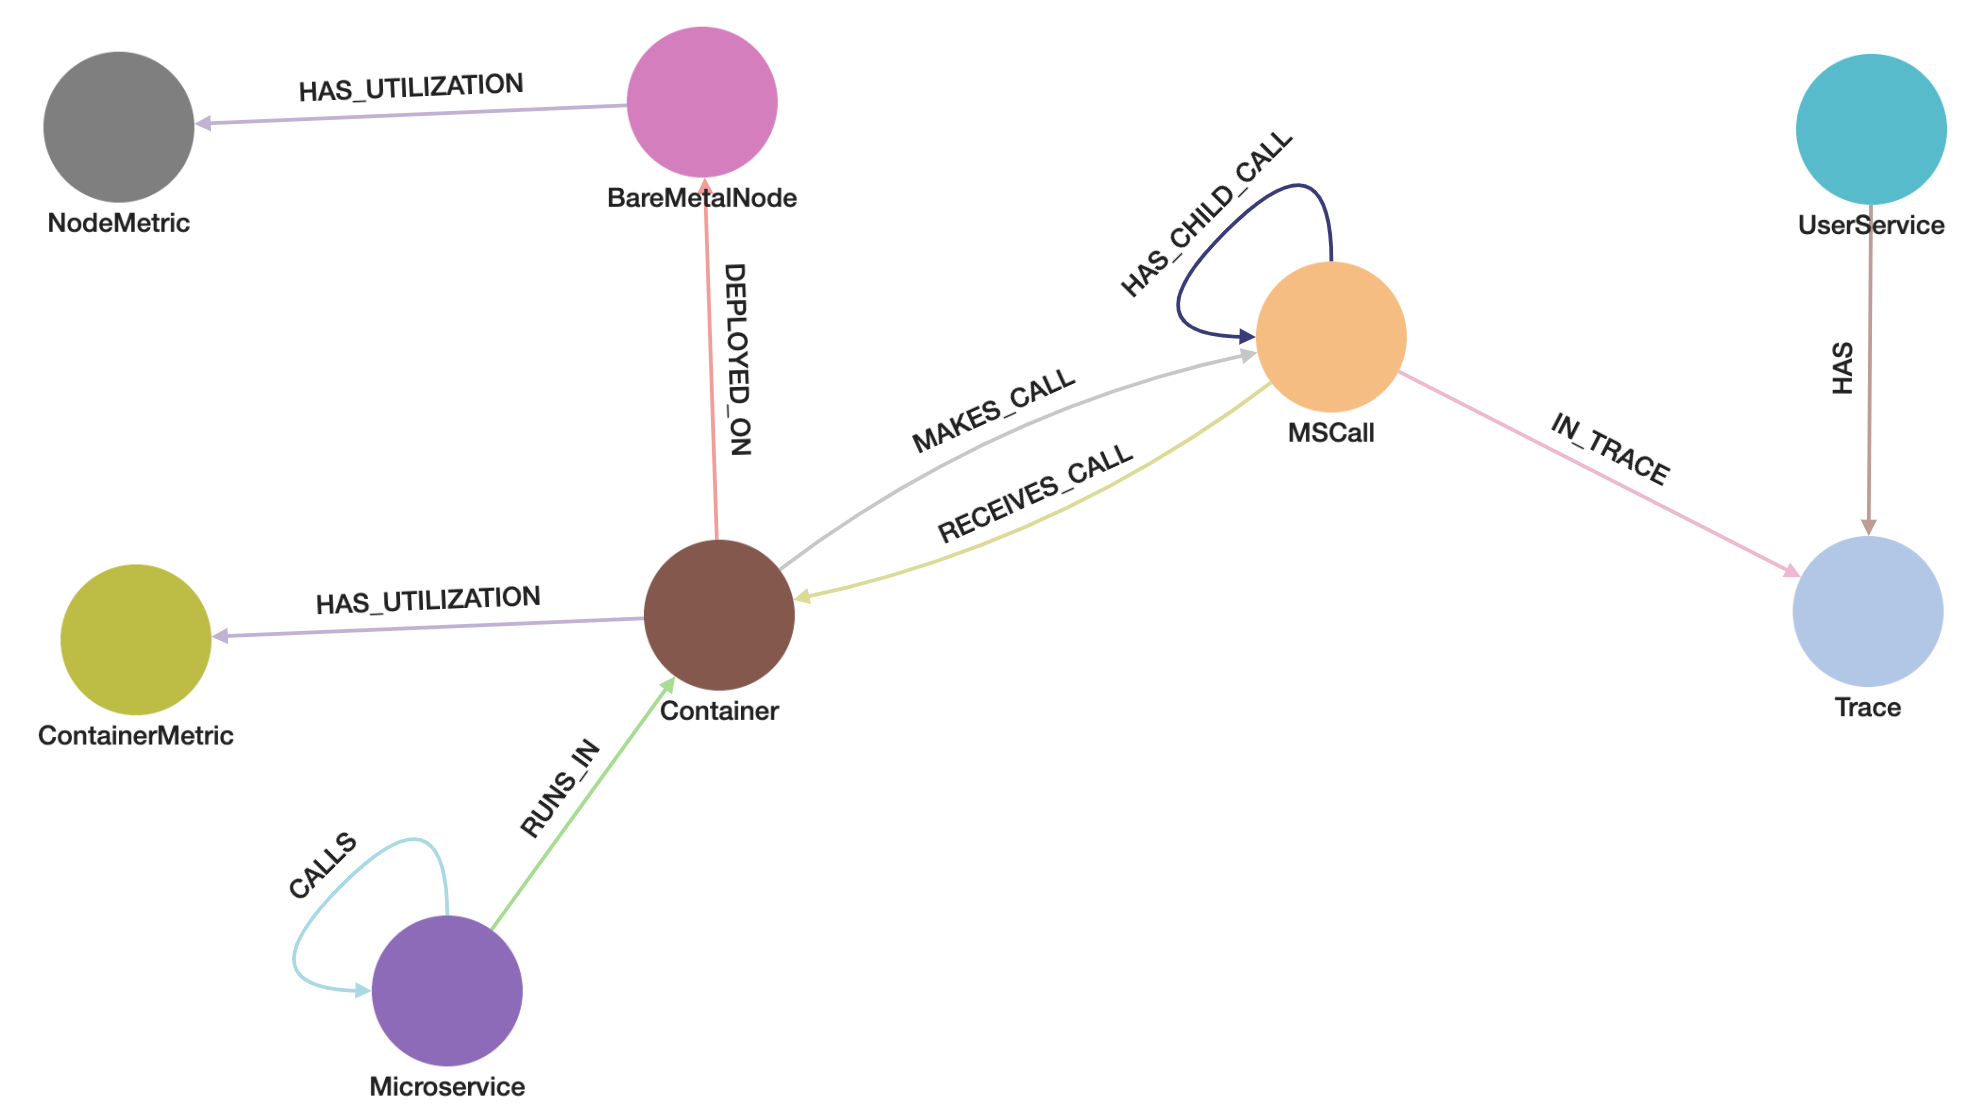

In [3]:
from pyTigerGraph.datasets import Datasets

# First download the dataset
dataset = Datasets("DigitalInfra")

A folder with name DigitalInfra already exists in ./tmp. Skip downloading.


In [4]:
# Then ingest it into the database. If your database doesn't have token
# authentication enabled, then set `getToken` to False. Databases on 
# TigerGraph Cloud always have token authentication enabled.
conn.ingestDataset(dataset, getToken=True)

---- Checking database ----
---- Creating graph ----
The graph DigitalInfra is created.
---- Creating schema ----
Using graph 'DigitalInfra'
Successfully created schema change jobs: [create_digital_infra_graph].
Kick off schema change job create_digital_infra_graph
Doing schema change on graph 'DigitalInfra' (current version: 0)
Trying to add local vertex 'Microservice' to the graph 'DigitalInfra'.
Trying to add local vertex 'Container' to the graph 'DigitalInfra'.
Trying to add local vertex 'BareMetalNode' to the graph 'DigitalInfra'.
Trying to add local vertex 'NodeMetric' to the graph 'DigitalInfra'.
Trying to add local vertex 'ContainerMetric' to the graph 'DigitalInfra'.
Trying to add local vertex 'UserService' to the graph 'DigitalInfra'.
Trying to add local vertex 'Trace' to the graph 'DigitalInfra'.
Trying to add local vertex 'MSCall' to the graph 'DigitalInfra'.
Trying to add local edge 'RUNS_IN' and its reverse edge 'reverse_RUNS_IN' to the graph 'DigitalInfra'.
Trying to add

## Query

CoPilot comes with a few basic DB functions pre-registered for counting and obtaining vertices or edges. So to answer those kinds of question, we don't need anything extra.

In [7]:
# Now we can ask ours questions.
conn.ai.query("How many servers are there?")
# If successful, you should see there are 46148 servers.

{'natural_language_response': 'There are 46148 servers.',
 'answered_question': True,
 'query_sources': {'function_call': "getVertexCount('BareMetalNode')",
  'result': 46148,
  'reasoning': "The function getVertexCount is used because we need to count the number of vertices of a specific type, in this case 'BareMetalNode'. The function returns the number of vertices of the specified type, which is exactly what the question is asking for."}}

If a particular GSQL query is needed to answer any question, the query has to be registered with CoPilot. Obviously, the query also has to be installed so it can be called. Below we install a query that looks up microservices depending on a given microservice and CoPilot will use it to answer questions regarding dependencies between the microservices.

In [8]:
# First, install the GSQL query. It might take one minute or two to install.
# If it is already installed, you can skip this step.
print(conn.gsql("""
USE GRAPH DigitalInfra

CREATE OR REPLACE DISTRIBUTED QUERY ms_dependency_chain(VERTEX<Microservice> microservice, INT depth = 3) FOR GRAPH DigitalInfra { 
  SetAccum<EDGE> @@dependency_edges;
  SetAccum<VERTEX> @@dependencies;
  start = {microservice};
  
  FOREACH i IN RANGE[0, depth-1] DO
    start = SELECT t FROM start:s -(reverse_CALLS:e)-> Microservice:t
            ACCUM @@dependency_edges += e
            POST-ACCUM @@dependencies += t;
  END;
  PRINT start;
  PRINT @@dependencies, @@dependency_edges;
}

INSTALL QUERY ms_dependency_chain
"""))

'Using graph \'DigitalInfra\'\nSuccessfully created queries: [ms_dependency_chain].\nStart installing queries, about 1 minute ...\nms_dependency_chain query: curl -X GET \'https://127.0.0.1:9000/query/DigitalInfra/ms_dependency_chain?microservice=VALUE&[depth=VALUE]\'. Add -H "Authorization: Bearer TOKEN" if authentication is enabled.\nSelect \'m1\' as compile server, now connecting ...\nNode \'m1\' is prepared as compile server.\n\n[                                                                                     ] 0% (0/1)   \n[                                                                                     ] 0% (0/1)   \n[======                                                                               ] 7% (0/1)   \n[============                                                                         ] 14% (0/1)  \n[==================                                                                   ] 21% (0/1)  \n[=========================                                

In [9]:
# Then register the query with CoPilot. The following information about the query
# are required for registration. Those information (especially the docstring) are
# used by the LLM to identify the right query to answer a given question.
custom_query = {
    "function_header": "ms_dependency_chain",
    "description": "Finds dependents of a given microservice up to k hops.",
    "docstring": "Finds dependents of a given microservice. Useful for determining effects of downtime for upgrades or bugs. Run the query with `runInstalledQuery('ms_dependency_chain', params={'microservice': 'INSERT_MICROSERVICE_ID_HERE', 'depth': INSERT_DEPTH_HERE})`. Depth defaults to 3.",
    "param_types": {"microservice": "str", "depth": "int"}
}

# Register the query
conn.ai.registerCustomQuery(
    custom_query["function_header"], 
    custom_query["description"], 
    custom_query["docstring"], 
    custom_query["param_types"])

['e310ba67-a7ad-4c46-a112-4a318b2f0007']

In [12]:
# Finally, let's ask a more complex question.
conn.ai.query("What microservices are immediately impacted if microservice MS_61242 goes down?")
# If successful, you should see miscroservices MS_5489, MS_35418, and MS_57548.

{'natural_language_response': 'The microservices that are immediately impacted if microservice MS_61242 goes down are MS_5489, MS_35418, and MS_57548.',
 'answered_question': True,
 'query_sources': {'function_call': "runInstalledQuery('ms_dependency_chain', params={'microservice': 'MS_61242', 'depth': 1})",
  'result': [{'start': [{'v_id': 'MS_35418',
      'v_type': 'Microservice',
      'attributes': {'id': ''}},
     {'v_id': 'MS_57548', 'v_type': 'Microservice', 'attributes': {'id': ''}},
     {'v_id': 'MS_5489', 'v_type': 'Microservice', 'attributes': {'id': ''}}]},
   {'@@dependencies': ['MS_5489', 'MS_35418', 'MS_57548'],
    '@@dependency_edges': [{'e_type': 'reverse_CALLS',
      'from_id': 'MS_61242',
      'from_type': 'Microservice',
      'to_id': 'MS_57548',
      'to_type': 'Microservice',
      'directed': True,
      'attributes': {}},
     {'e_type': 'reverse_CALLS',
      'from_id': 'MS_61242',
      'from_type': 'Microservice',
      'to_id': 'MS_35418',
      'to_